# Power analysis of interaction effects

In this example, we are going to perform a simulation analysis of a regression model and use it to determine the power to detect so-called "main" and "interaction" effects.

Suppose that the value of a house, $H_i>0$, depends linearly on its square footage, $S_i>0$ and whether it has a swimming pool, $P_i\in\{0,1\}$. Further, we believe that there is probably an interaction effect: if a house has a swimming pool, increases in its size have greater impacts on its price. One way to represent this relationship is via the below model:

$H_i = \alpha + \beta S_i + \gamma P_i + \delta P_i S_i + \epsilon_i$.

where $\epsilon_i\sim N(0, \sigma)$ represents a random error term.

Explain why this model allows such an interaction effect.

If $P_i=0$, then the average relationship is:

$H_i = \alpha + \beta S_i$.

If $P_i=1$, the relationship becomes:

$H_i = (\alpha + \gamma) + (\beta + \delta) S_i$.

In other words, $\delta$ effectively increases the slope, leading to a greater impact of changes in house size on its price.

$\delta$ is known as an interaction effect; $\beta$ and $\gamma$ are known as main effects.

Generate $(H_i, S_i, P_i)$ data for 100 houses by generating:

$S_i\sim N(0, 1)$

$P_i \sim \text{Bernoulli}(0.5)$,

with $\alpha=0$, $\beta=0.5$, $\gamma=0.5$, $\delta=0.1$, $\sigma=0.5$. (Note, here we are assuming scaled units for everything!)

In [1]:
import numpy as np
import scipy
import statsmodels.api as sm
from plotnine import *
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def house_price(S, P, parameters):
    alpha = parameters['alpha']
    beta = parameters['beta']
    gamma = parameters['gamma']
    delta = parameters['delta']
    sigma = parameters['sigma']
    P = alpha + beta * S + gamma * P + delta * S * P + np.random.normal(0, sigma, 1)[0]
    return P

In [3]:
import scipy.stats
nhouses = 100
S = np.random.normal(0, 1, nhouses)
P = scipy.stats.bernoulli.rvs(0.5, 0, nhouses)
alpha = 0
beta = 0.5
gamma = 0.5
delta = 0.1
sigma = 1
parameters = {'alpha': alpha, 'beta': beta, 'gamma': gamma, 'delta': delta, 'sigma': sigma}
H = []
for i in range(nhouses):
    H.append(house_price(S[i], P[i], parameters))

Plot house price vs size for houses with and without swimming pools.

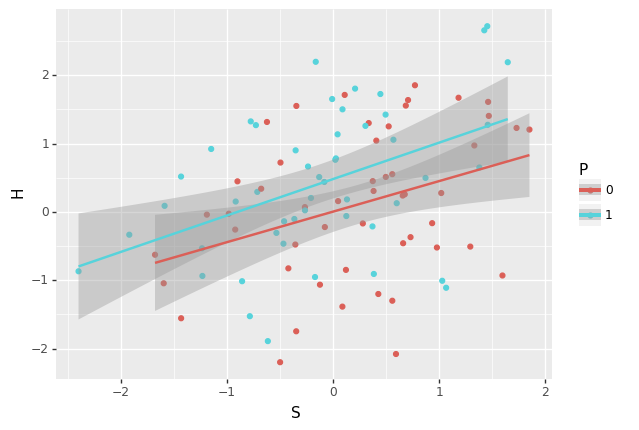

<ggplot: (350358493)>

In [4]:
df = pd.DataFrame({'H': H, 'S': S, 'P': P})
df["P"] = df["P"].astype("category")
(ggplot(df, aes('S', 'H', colour='P')) +
geom_point() +
geom_smooth(method='lm'))

Now write a function to perform the linear regression of the model. Your function should return the coefficients and $p$-values on $\gamma$ and $\delta$.

In [5]:
def house_regression(df):
    H = df["H"]
    X = df[["S", "P"]]
    X["SP"] = df["S"] * df["P"]
    X = sm.add_constant(X, prepend=False)
    model = sm.OLS(H, X)
    fit = model.fit()
    params = fit.params[0:3]

    coeff = fit.params
    p = fit.pvalues
    
    return coeff["P"], coeff["SP"], p["P"], p["SP"]

Create a function which generates $S$, $P$ and $H$ for a given number of houses, which uses the same set of parameters as before. Then using these variables, performs a regression and returns the coefficients and $p$-values on $\gamma$ and $\delta$.

In [6]:
def create_variables_run_regression(nhouses, parameters):
    S = np.random.normal(0, 1, nhouses)
    P = scipy.stats.bernoulli.rvs(0.5, 0, nhouses)
    H = []
    for i in range(nhouses):
        H.append(house_price(S[i], P[i], parameters))
    df = pd.DataFrame({'H': H, 'S': S, 'P': P})
    return house_regression(df)

Using 100 iterates at a range of sample sizes from 20 to 5000, calculate the power to detect $\gamma$ and $\delta$ at the 5% level.

In [7]:
def correct_sign(coeff, p):
    if coeff > 0 and p < 0.05:
        return 1
    else:
        return 0
def run_replicate(nhouses, parameters):
    gamma, delta, pgamma, pdelta = create_variables_run_regression(nhouses, parameters)
    return correct_sign(gamma, pgamma), correct_sign(delta, pdelta)
def run_replicates(niterates, nhouses, parameters):
    gamma_correct = 0
    delta_correct = 0
    for i in range(niterates):
        g_correct, d_correct = run_replicate(nhouses, parameters)
        gamma_correct += g_correct
        delta_correct += d_correct
    return gamma_correct / niterates, delta_correct / niterates

In [8]:
sample_sizes = [20, 50, 100, 200, 500, 800, 1000, 2000, 5000]
niterates = 100
gamma_correct = []
delta_correct = []
for sample in sample_sizes:
    g_correct, d_correct = run_replicates(niterates, sample, parameters)
    gamma_correct.append(g_correct)
    delta_correct.append(d_correct)

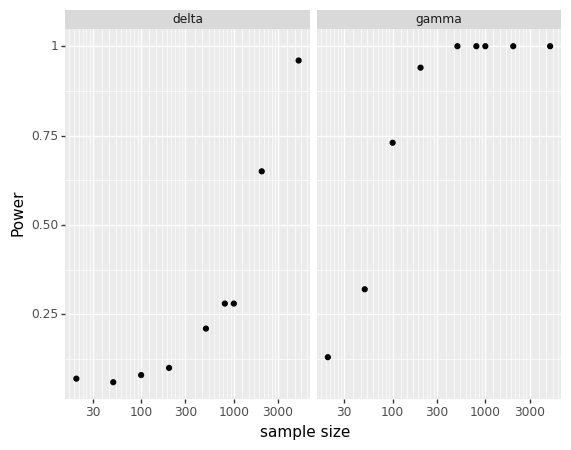

<ggplot: (352607169)>

In [9]:
df = pd.DataFrame({'sample size': sample_sizes, 'gamma': gamma_correct, 'delta': delta_correct})
df = pd.melt(df, id_vars='sample size')
(ggplot(df, aes(x='sample size', y='value')) +
geom_point() +
facet_wrap('variable') +
ylab('Power') +
scale_x_log10())

What do you conclude about the power to detect interaction effects compared with main effects?

It takes a great deal more data to detect interaction effects! Roughly, an order of magnitude more.

Using a sample size of 100, carry out 1000 replicates where, in each, you estimate $\delta$ and its $p$-value. Draw a histogram of the delta values: how does the distribution compare to the true value?

In [10]:
def run_replicate_estimate(nhouses, parameters):
    _, delta, _, pdelta = create_variables_run_regression(nhouses, parameters)
    return delta, pdelta

In [11]:
niterates = 1000
nhouses = 100
deltas = []
ps = []
for i in range(niterates):
    delta, pdelta = run_replicate_estimate(nhouses, parameters)
    deltas.append(delta)
    ps.append(pdelta)

/usr/local/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 24'. Pick better value with 'binwidth'.


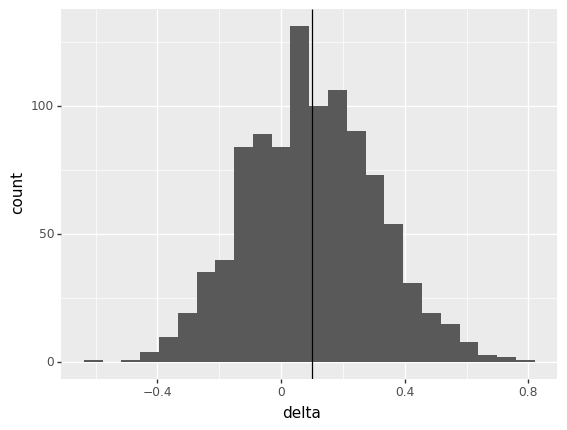

<ggplot: (352835153)>

In [15]:
df = pd.DataFrame({'delta': deltas, 'p': ps})
(ggplot(df, aes('delta')) +
geom_histogram() +
geom_vline(xintercept=parameters['delta']))

It's roughly centered on it: in other words, our estimator appears unbiased.

Now, keep only those $\delta$ values which are of the correct sign and where $p<0.05$. How do those estimates of delta compare to the true values?

/usr/local/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 8'. Pick better value with 'binwidth'.


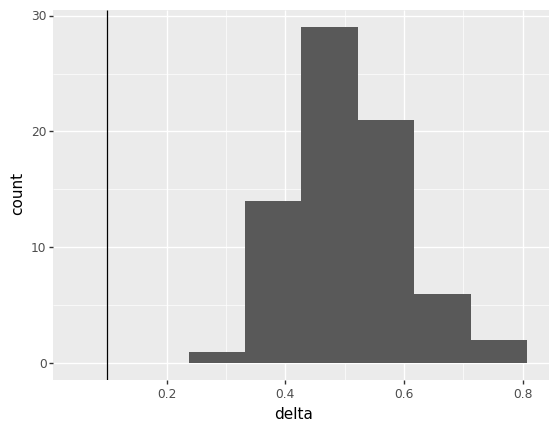

<ggplot: (352953821)>

In [14]:
df_short = df.query('p < 0.05')
df_short = df_short.query('delta > 0')

(ggplot(df_short, aes('delta')) +
geom_histogram() +
geom_vline(xintercept=parameters['delta']))

What do you conclude about the risks of using tests with weak power?

If you use them and find a significant effect, it'll likely be a large overestimate!